In [1]:
import datetime
# import pandas_datareader.data as web
from pandas_datareader import data as web

In [2]:
start= datetime.datetime(2015,1,1)
end= datetime.datetime.today()

aapl = web.DataReader('AAPL', 'yahoo', start, end)
ibm = web.DataReader('IBM', 'yahoo', start, end)
amzn = web.DataReader('AMZN', 'yahoo', start, end)

#Alternative way to download portfolio data:
#aapl = quandl.get('WIKI/AAPL.11',start_date=start,end_date=end)

aapl.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-05-11,155.449997,145.809998,153.500000,146.500000,142689800.0,146.500000
2022-05-12,146.199997,138.800003,142.770004,142.559998,182602000.0,142.559998
2022-05-13,148.100006,143.110001,144.589996,147.110001,113787000.0,147.110001
2022-05-16,147.520004,144.179993,145.550003,145.539993,86541200.0,145.539993
2022-05-17,149.330002,147.070007,148.860001,147.630005,16464353.0,147.630005


Text(0.5, 1.0, 'AMZN')

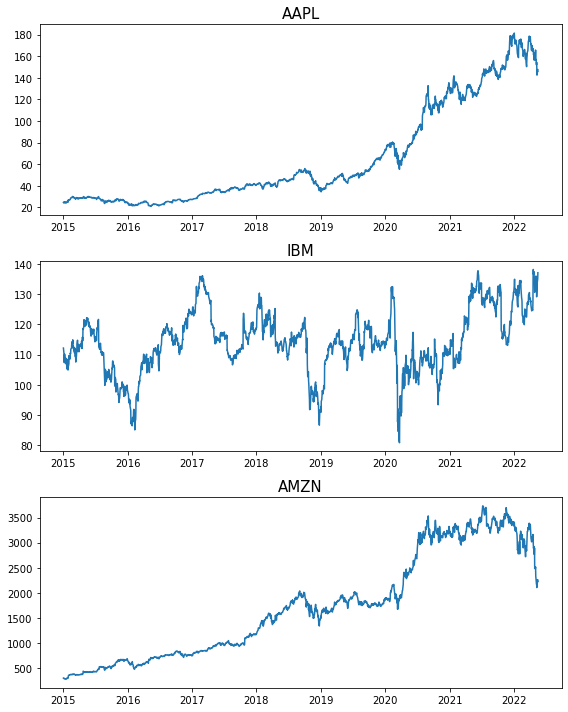

In [3]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 1, sharey=False, tight_layout=True,figsize=(8, 10))
axs[0].plot(aapl['Adj Close'])
axs[0].set_title('AAPL', size = 15)
axs[1].plot(ibm['Adj Close'])
axs[1].set_title('IBM', size = 15)
axs[2].plot(amzn['Adj Close'])
axs[2].set_title('AMZN', size = 15)

In [4]:
#library import
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM

In [5]:
# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(aapl) + 1, 1)

# TAKING DIFFERENT INDICATORS FOR PREDICTION
aapl_adj = aapl["Adj Close"]
ibm_adj = ibm["Adj Close"]
amzn_adj = amzn["Adj Close"]

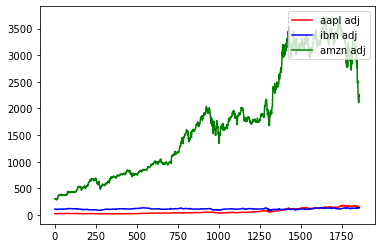

In [6]:
# PLOTTING ALL INDICATORS IN ONE PLOT
plt.plot(obs, aapl_adj, 'r', label = 'aapl adj')
plt.plot(obs, ibm_adj, 'b', label = 'ibm adj')
plt.plot(obs, amzn_adj, 'g', label = 'amzn adj')
plt.legend(loc = 'upper right')
plt.show()

In [7]:
diff = lambda x: x.diff(1)
log_diff = lambda x: 100*np.log(x).diff(1)

aapl_adj_return = aapl_adj.transform({"Adj Close": log_diff}).dropna()
ibm_adj_return = ibm_adj.transform({"Adj Close": log_diff}).dropna()
amzn_adj_return = amzn_adj.transform({"Adj Close": log_diff}).dropna()

In [8]:
print('')
print('='*50)
print('AAPL')
print('-'*50)
print(aapl_adj_return.describe())
print('-'*50)

print('')
print('='*50)
print('IBM')
print('-'*50)
print(ibm_adj_return.describe())
print('-'*50)

print('')
print('='*50)
print('AMZN')
print('-'*50)
print(amzn_adj_return.describe())
print('-'*50)


AAPL
--------------------------------------------------
         Adj Close
count  1856.000000
mean      0.096379
std       1.846711
min     -13.770813
25%      -0.697854
50%       0.089453
75%       1.020551
max      11.315764
--------------------------------------------------

IBM
--------------------------------------------------
         Adj Close
count  1856.000000
mean      0.010809
std       1.569334
min     -13.754767
25%      -0.648499
50%       0.049132
75%       0.717163
max      10.706848
--------------------------------------------------

AMZN
--------------------------------------------------
         Adj Close
count  1856.000000
mean      0.107187
std       1.988182
min     -15.139797
25%      -0.792533
50%       0.121882
75%       1.071768
max      13.217792
--------------------------------------------------


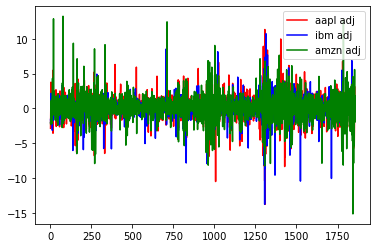

In [9]:
obs = np.arange(1, len(aapl), 1)

plt.plot(obs, aapl_adj_return, 'r', label = 'aapl adj')
plt.plot(obs, ibm_adj_return, 'b', label = 'ibm adj')
plt.plot(obs, amzn_adj_return, 'g', label = 'amzn adj')
plt.legend(loc = 'upper right')
plt.show()

In [10]:
class WindowGenerator():
 
    def __init__(
        self, input_width, label_width, shift,
        train_df, val_df, test_df,
        label_columns=None
    ):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
 
        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }
        self.column_indices = {
            name: i for i, name in enumerate(train_df.columns)
        }
 
        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
 
        self.total_window_size = input_width + shift
 
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
 
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
 
    def __repr__(self):
        return '\n'.join(
            [
                f'Total window size: {self.total_window_size}',
                f'Input indices: {self.input_indices}',
                f'Label indices: {self.label_indices}',
                f'Label column name(s): {self.label_columns}'
            ]
        )
 
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [
                    labels[:, :, self.column_indices[name]]
                    for name in self.label_columns
                ], axis=-1
            )
 
        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
 
        return inputs, labels
 
    def plot(self, model=None, plot_col='Adj Close', max_subplots=3):
   
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
 
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col}')
            plt.plot(
                self.input_indices,
                inputs[n, :, plot_col_index],
                label='Inputs', marker='.', zorder=-10
            )
 
            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index
 
            if label_col_index is None:
                continue
 
            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
 
            if model is not None:
                predictions = model(inputs)
                plt.scatter(
                    self.label_indices, predictions[n, :, 0],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64
                )
 
            if n == 0:
                plt.legend()
 
        plt.xlabel('Months')
 
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=24,
        )
 
        ds = ds.map(self.split_window)
 
        return ds
 
    @property
    def train(self):
        return self.make_dataset(self.train_df)
 
    @property
    def val(self):
        return self.make_dataset(self.val_df)
 
    @property
    def test(self):
        return self.make_dataset(self.test_df)
 
    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
 
        return result

# AAPL

In [11]:
# TRAIN-TEST-VAL SPLIT
n = aapl_adj_return.shape[0]

# Training data
train_n = int(n*0.7)
train_df = aapl_adj_return.iloc[0:train_n, :]

# Validation data
val_n = int(n*0.2)
val_df = aapl_adj_return.iloc[train_n:train_n+val_n, :]

# Testing data
test_df = aapl_adj_return.iloc[train_n+val_n:, :]

In [12]:
### Normalization
# train_mean = train_aapl.mean() # use the same set of mean and sd on all sets of data
# train_std = train_aapl.std()

# train_aapl = (train_aapl - train_mean) / train_std
# val_aapl = (val_aapl - train_mean) / train_std
# test_aapl = (test_aapl - train_mean) / train_std

Text(0.5, 0, 'Date')

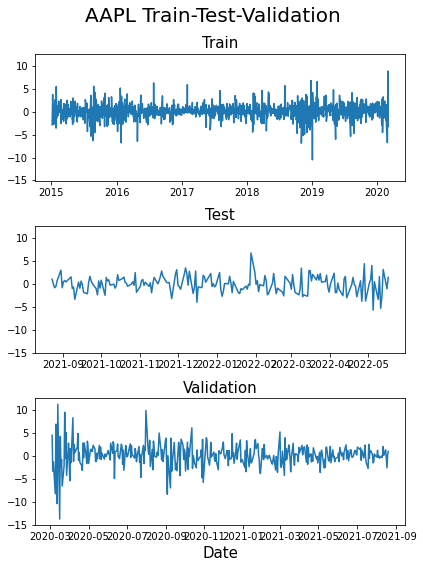

In [13]:
fig, axs = plt.subplots(3, 1, sharey=True, tight_layout=True,figsize=(6, 8))
axs[0].plot(train_df["Adj Close"])
axs[0].set_title('Train', size = 15)
axs[1].plot(test_df["Adj Close"])
axs[1].set_title('Test', size = 15)
axs[2].plot(val_df["Adj Close"])
axs[2].set_title('Validation', size = 15)
fig.suptitle('AAPL Train-Test-Validation', size = 20)
plt.xlabel("Date", size = 15)

In [14]:
INPUT_WIDTH = 24
LABEL_WIDTH = 1 ## how many y to generate
SHIFT = 1 ## shift the last value in x to y

eval_window = WindowGenerator(
    input_width=INPUT_WIDTH, label_width=LABEL_WIDTH,
    shift=SHIFT, label_columns=["Adj Close"], train_df=train_df, test_df=test_df, val_df=val_df
)

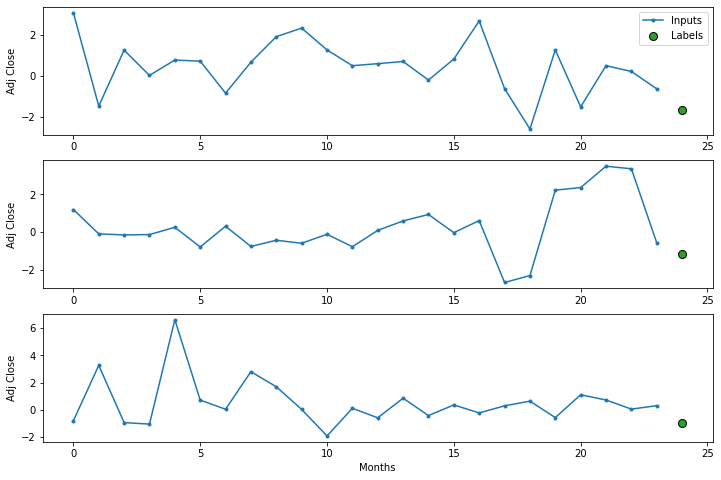

In [15]:
eval_window.plot()

In [16]:
MAX_EPOCHS = 250

def compile_and_fit(model, window, patience=5): ## patience: MSE not improve after # of patience iteration, stop

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min'
    )

    model.compile(
        loss=tf.losses.MeanSquaredError(),
        optimizer=tf.optimizers.RMSprop(),
    )


    history = model.fit(
        window.train, epochs=MAX_EPOCHS,
        validation_data=window.val,
        callbacks=[early_stopping]
    )

    return history

## Model 1: Baseline

In [17]:
class BaselinePricePrediction(tf.keras.Model):
    def __init__(self, gamma, label_index=None):
        super().__init__()
        self.gamma = gamma
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            x = self.gamma*inputs + (1-self.gamma)*0
        else:
            x = self.gamma*inputs[:, :, self.label_index] + (1-self.gamma)*0

        return x[:, :, tf.newaxis]

In [18]:
baseline = BaselinePricePrediction(gamma=0.8, label_index=eval_window.column_indices["Adj Close"]) ## try change gamma value here
baseline.compile(loss=tf.losses.MeanSquaredError())

val_performance = {}
performance = {}

val_performance['Baseline'] = baseline.evaluate(eval_window.val)
performance['Baseline'] = baseline.evaluate(eval_window.test, verbose=0)

15/15 [==============================] - 0s 722us/step - loss: 7.5127


In [19]:
baseline.evaluate(eval_window.train)

54/54 [==============================] - 0s 754us/step - loss: 4.0953


4.095341205596924

In [20]:
val_performance

{'Baseline': 7.512689590454102}

In [21]:
performance

{'Baseline': 5.583772659301758}

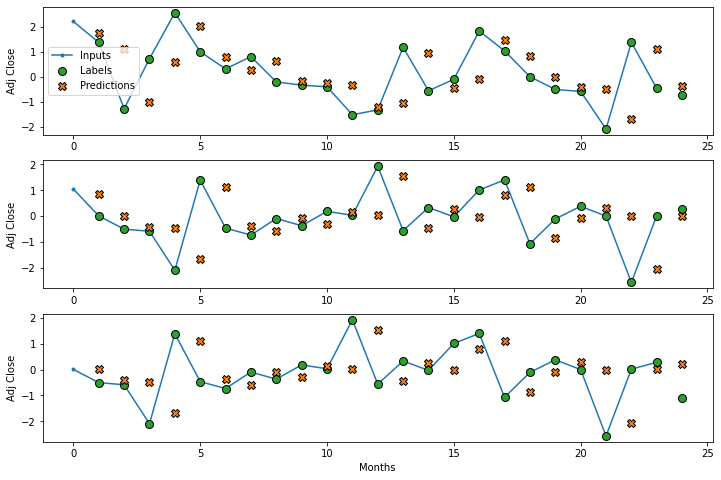

In [22]:
wide_window_baseline = WindowGenerator(
    input_width=INPUT_WIDTH, label_width=INPUT_WIDTH,
    shift=SHIFT, label_columns=["Adj Close"], train_df=train_df, test_df=test_df, val_df=val_df
)

wide_window_baseline.plot(baseline, max_subplots=3)

## Model 2: Convolution 1D

In [23]:
CONV_WIDTH = 22 #12 ## window size. 这里Chase用的是过去一年的data，我们是daily data所以需要改一下

conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1, train_df=train_df, test_df=test_df, val_df=val_df
)

conv_model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv1D(filters=8, kernel_size=(CONV_WIDTH,), activation="relu"),
        tf.keras.layers.Dense(units=4, activation="relu"),
        tf.keras.layers.Dense(units=1),
    ]
)

compile_and_fit(conv_model, conv_window)

val_performance['Conv1D'] = conv_model.evaluate(eval_window.val)
performance['Conv1D'] = conv_model.evaluate(eval_window.test, verbose=0)

Epoch 1/250
54/54 [==============================] - 1s 4ms/step - loss: 2.5734 - val_loss: 4.2155
Epoch 2/250
54/54 [==============================] - 0s 3ms/step - loss: 2.5474 - val_loss: 4.2216
Epoch 3/250
54/54 [==============================] - 0s 3ms/step - loss: 2.5341 - val_loss: 4.2261
Epoch 4/250
54/54 [==============================] - 0s 3ms/step - loss: 2.5239 - val_loss: 4.2231
Epoch 5/250
54/54 [==============================] - 0s 3ms/step - loss: 2.5145 - val_loss: 4.2244
Epoch 6/250
15/15 [==============================] - 0s 1ms/step - loss: 4.1266


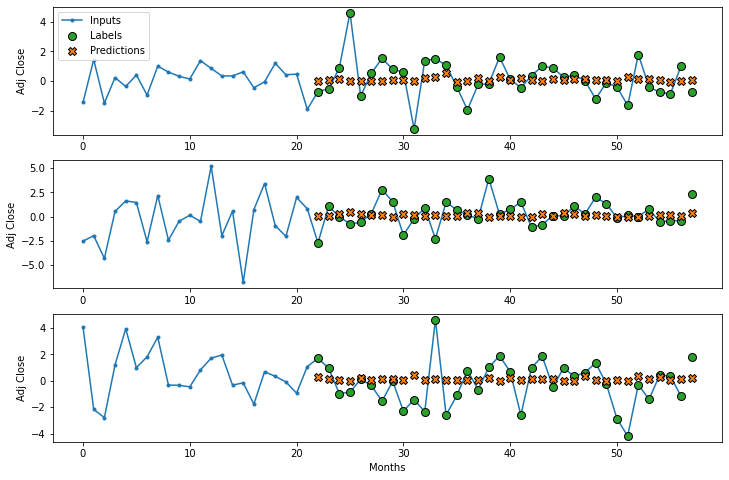

In [24]:
wide_window_conv = WindowGenerator(
    input_width=36 + (CONV_WIDTH - 1),
    label_width=36,
    shift=SHIFT, train_df=train_df, test_df=test_df, val_df=val_df
)

wide_window_conv.plot(conv_model, max_subplots=3)

## Model 3: Simple RNN

In [28]:
srnn_model = tf.keras.Sequential(
    [
        tf.keras.layers.SimpleRNN(8, activation="relu", return_sequences=False), ## 8 filters
        tf.keras.layers.Dense(4),
        tf.keras.layers.Dense(1),
    ]
)

compile_and_fit(srnn_model, eval_window)

val_performance['SimpleRNN'] = srnn_model.evaluate(eval_window.val)
performance['SimpleRNN'] = srnn_model.evaluate(eval_window.test, verbose=0)

Epoch 1/250
54/54 [==============================] - 1s 6ms/step - loss: 3.7146 - val_loss: 4.5919
Epoch 2/250
54/54 [==============================] - 0s 5ms/step - loss: 2.8269 - val_loss: 4.2506
Epoch 3/250
54/54 [==============================] - 0s 4ms/step - loss: 2.6354 - val_loss: 4.1367
Epoch 4/250
54/54 [==============================] - 0s 4ms/step - loss: 2.5820 - val_loss: 4.0990
Epoch 5/250
54/54 [==============================] - 0s 4ms/step - loss: 2.5553 - val_loss: 4.1256
Epoch 6/250
54/54 [==============================] - 0s 5ms/step - loss: 2.5495 - val_loss: 4.1784
Epoch 7/250
54/54 [==============================] - 0s 4ms/step - loss: 2.5440 - val_loss: 4.1585
Epoch 8/250
54/54 [==============================] - 0s 4ms/step - loss: 2.5387 - val_loss: 4.1440
Epoch 9/250
15/15 [==============================] - 0s 2ms/step - loss: 4.1503


In [29]:
val_performance

{'Baseline': 7.512689590454102,
 'Conv1D': 4.126590251922607,
 'SimpleRNN': 4.1503496170043945}

In [30]:
performance

{'Baseline': 5.583772659301758,
 'Conv1D': 3.6892974376678467,
 'SimpleRNN': 3.581148386001587}

In [83]:
# #### 这个plot的error msg我看不明白

# wide_window_conv = WindowGenerator(
#     input_width=36 + (CONV_WIDTH - 1),
#     label_width=36,
#     shift=SHIFT, train_df=train_df, test_df=test_df, val_df=val_df
# )

# wide_window_conv.plot(srnn_model, max_subplots=3)

## Model 4: LSTM

In [31]:
lstm_model = tf.keras.Sequential(
    [
        tf.keras.layers.LSTM(8, activation="relu", return_sequences=False),
        tf.keras.layers.Dense(4),
        tf.keras.layers.Dense(1),
    ]
)

compile_and_fit(lstm_model, eval_window)

val_performance['LSTM'] = lstm_model.evaluate(eval_window.val)
performance['LSTM'] = lstm_model.evaluate(eval_window.test, verbose=0)

Epoch 1/250
54/54 [==============================] - 1s 9ms/step - loss: 2.5571 - val_loss: 4.1853
Epoch 2/250
54/54 [==============================] - 0s 6ms/step - loss: 2.5531 - val_loss: 4.1854
Epoch 3/250
54/54 [==============================] - 0s 7ms/step - loss: 2.5500 - val_loss: 4.1836
Epoch 4/250
54/54 [==============================] - 0s 6ms/step - loss: 2.5476 - val_loss: 4.1816
Epoch 5/250
54/54 [==============================] - 0s 6ms/step - loss: 2.5472 - val_loss: 4.1756
Epoch 6/250
54/54 [==============================] - 0s 6ms/step - loss: 2.5462 - val_loss: 4.1702
Epoch 7/250
54/54 [==============================] - 0s 6ms/step - loss: 2.5431 - val_loss: 4.1607
Epoch 8/250
54/54 [==============================] - 0s 7ms/step - loss: 2.5443 - val_loss: 4.1608
Epoch 9/250
54/54 [==============================] - 0s 7ms/step - loss: 2.5417 - val_loss: 4.1572
Epoch 10/250
54/54 [==============================] - 0s 7ms/step - loss: 2.5405 - val_loss: 4.1534
Epoch 11/

In [85]:
val_performance

{'Baseline': 7.808182239532471,
 'Conv1D': 4.322494983673096,
 'SimpleRNN': 4.275979518890381,
 'LSTM': 4.318776607513428}

In [86]:
performance

{'Baseline': 5.540596961975098,
 'Conv1D': 3.6186769008636475,
 'SimpleRNN': 3.597369909286499,
 'LSTM': 3.595818519592285}

In [88]:
# wide_window_conv = WindowGenerator(
#     input_width=36 + (CONV_WIDTH - 1),
#     label_width=36,
#     shift=SHIFT, train_df=train_df, test_df=test_df, val_df=val_df
# )

# wide_window_conv.plot(lstm_model, max_subplots=3)

## Model 5: GRU

In [89]:
gru_model = tf.keras.Sequential(
    [
        tf.keras.layers.GRU(8, activation="relu", return_sequences=False),
        tf.keras.layers.Dense(4),
        tf.keras.layers.Dense(1),
    ]
)

compile_and_fit(gru_model, eval_window)

val_performance['GRU'] = gru_model.evaluate(eval_window.val)
performance['GRU'] = gru_model.evaluate(eval_window.test, verbose=0)

Epoch 1/250
54/54 [==============================] - 2s 10ms/step - loss: 2.5520 - val_loss: 4.3546
Epoch 2/250
54/54 [==============================] - 0s 8ms/step - loss: 2.5455 - val_loss: 4.3305
Epoch 3/250
54/54 [==============================] - 0s 8ms/step - loss: 2.5413 - val_loss: 4.3220
Epoch 4/250
54/54 [==============================] - 0s 8ms/step - loss: 2.5406 - val_loss: 4.3138
Epoch 5/250
54/54 [==============================] - 1s 9ms/step - loss: 2.5393 - val_loss: 4.3197
Epoch 6/250
54/54 [==============================] - 0s 7ms/step - loss: 2.5392 - val_loss: 4.3228
Epoch 7/250
54/54 [==============================] - 0s 7ms/step - loss: 2.5386 - val_loss: 4.3245
Epoch 8/250
54/54 [==============================] - 0s 7ms/step - loss: 2.5386 - val_loss: 4.3159
Epoch 9/250
15/15 [==============================] - 0s 3ms/step - loss: 4.3229


In [90]:
val_performance

{'Baseline': 7.808182239532471,
 'Conv1D': 4.322494983673096,
 'SimpleRNN': 4.275979518890381,
 'LSTM': 4.318776607513428,
 'GRU': 4.322872638702393}

In [91]:
performance

{'Baseline': 5.540596961975098,
 'Conv1D': 3.6186769008636475,
 'SimpleRNN': 3.597369909286499,
 'LSTM': 3.595818519592285,
 'GRU': 3.5913772583007812}

In [98]:
import pandas as pd
a = pd.DataFrame.from_dict(val_performance, orient = 'index', columns=["aapl_val"])
b = pd.DataFrame.from_dict(performance, orient = 'index', columns=["aapl_test"])
c = pd.concat([a, b],axis=1)
c

,aapl_val,aapl_test
Baseline,7.808182,5.540597
Conv1D,4.322495,3.618677
SimpleRNN,4.275980,3.597370
LSTM,4.318777,3.595819
GRU,4.322873,3.591377
